# Исследование данных о поведении пользователей сервиса аренды самокатов в разных городах

***Описание проекта:***

  ***В данном проекте мы познакомимся с тремя таблица, где содержится информация о поездках на самокате двух групп пользователей: с платной подпиской и без нее. Нам предстоит обработать данные, проанализировать параметры длительности и дистанции поездок для обеих групп пользователей по отдельности и вместе.***

  ***Собрав всю имеющуюся информацию в единый датафрейм, мы проверим 3 гипотезы. Результаты нашей работы в дальнейшем менеджеры используют для того, чтобы решить, нужно ли проводить различные акции для увеличения количества пользователей с подпиской. Будет ли это выгодно.***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from IPython.display import display
import seaborn as sns

#### Шаг 1. Загрузка данных

In [2]:
# сохраняем дарафреймы в переменные

users_data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQDmKRR8FSTwS3vegFErbzU2SQU9grPNyCo7ETNilJy0v7EpbkqjjWjsLGAZpEXN5mrtLz43JYz-nhP/pub?output=csv')
rides_data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSPgr9ANPhFnX12WL_W3ovk2P67SpRWauqz-5EQS1hUHxlFxXFE-pJYwd7Tas9-tNDzvkhcI-epIH9J/pub?output=csv')
subscriptions_data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRU-G4PJKghCyzc9B9-gs-pcIV6gW602qX4kcGIwUXZhCiQ1YV-vsZ0BWFCy8P7GJXtQTrTfNxNUfa3/pub?output=csv')

In [3]:
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides_data.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions_data.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Мы узнали основную информацию о трех датафреймах. 
Первый - "users_data" - содержит информацию о пользователях, их городах и типе подписки. Размер: 1565 строк, 5 столбцов
Второй - "rides_data" - о поездках, их продолительности и дате. Размер: 18068 строк, 4 столбца. В столбце с датой поездки нужно изменить тип данных.
Третий - "subscriptions_data" - создержит данные о стоимости поездок для пользователей с подпиской и без нее.

#### Шаг 2. Предобработка данных

In [9]:
# меняем тип данных object на datetime

rides_data['date'] = pd.to_datetime(rides_data['date'])
rides_data['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

In [10]:
# создаем столбце month с помощью метода библиотеки pandas

rides_data['month'] = pd.DatetimeIndex(rides_data['date']).month

# проверяем результат и смотрим, за какой период у нас есть данные

rides_data['month'].head()
print(rides_data['month'].unique())
rides_data['month'].nunique()

[ 1  4  8 10 11 12  3  6  7  2  5  9]


12

Теперь мы видим, что располагаем данными за весь год.

In [11]:
# проверяем есть ли дубликаты в датафрейме users_data и сколько их
users_data.duplicated().sum()

31

In [12]:
users_data['user_id'].value_counts().head(35)

user_id
209     2
807     2
611     2
43      2
737     2
47      2
1198    2
829     2
924     2
153     2
635     2
72      2
909     2
908     2
136     2
1045    2
1237    2
127     2
659     2
307     2
1245    2
121     2
666     2
108     2
297     2
809     2
293     2
16      2
422     2
403     2
204     2
1035    1
1041    1
1040    1
1039    1
Name: count, dtype: int64

In [13]:
# удаляем дубликаты строк и проверяем результат
users_data = users_data.drop_duplicates().reset_index() 
users_data.duplicated().sum()

0

In [14]:
# считаем пропуски в первом датафрейме
users_data.isna().sum()

index                0
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
# считаем дубликаты во втором датафрейме
rides_data.duplicated().sum()

0

In [16]:
# считаем пропуски во втором датафрейме
rides_data.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

В ходе предобработки данных мы удалили дубликаты строк из первого датафрейма с информацией о пользователях. Также узнали, что ни в одном датафрейме нет пропусков (в subscriptions_data всего 2 строки, поэтому проверять не нужно). Внесли два изменения в датафрейм "rides_data": исправили тип данных в столбце "date" и добавили исходя из него столбец с указанием номера месяца, в который была совершена поездка. 

#### Шаг 3. Исследовательский анализ данных

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


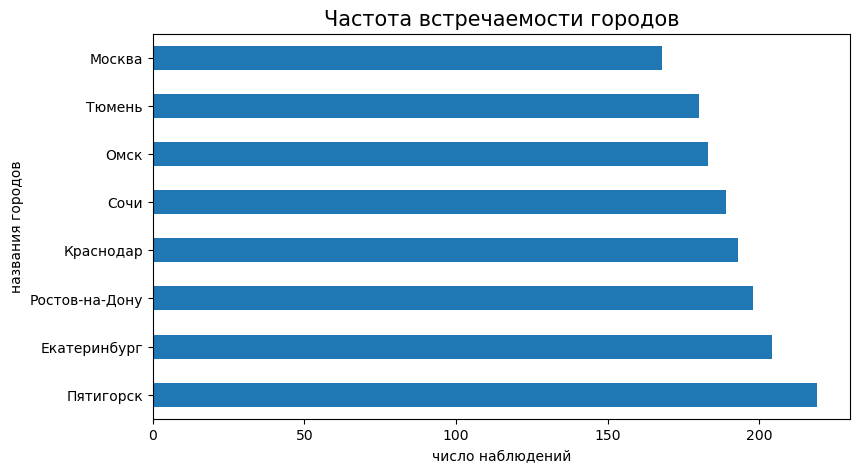

In [17]:
# считаем, как часто разные города встречаются в данных, также строим для этого график

print(users_data['city'].value_counts())
users_data['city'].value_counts().plot(kind='barh', figsize=(9,5))
plt.title("Частота встречаемости городов", fontsize=15)
plt.xlabel("число наблюдений", fontsize=10)
plt.ylabel("названия городов", fontsize=10)
plt.show()

На графике мы видим, что Москва встречается реже остальных 7 городов - 168 раз, первым по частоте оказался Пятигорск со значением 219. В целом нельзя сказать, что какой-то город выделяется, разница между самым маленьким и большим значениями - 50. 

subscription_type
free     835
ultra    699
Name: count, dtype: int64


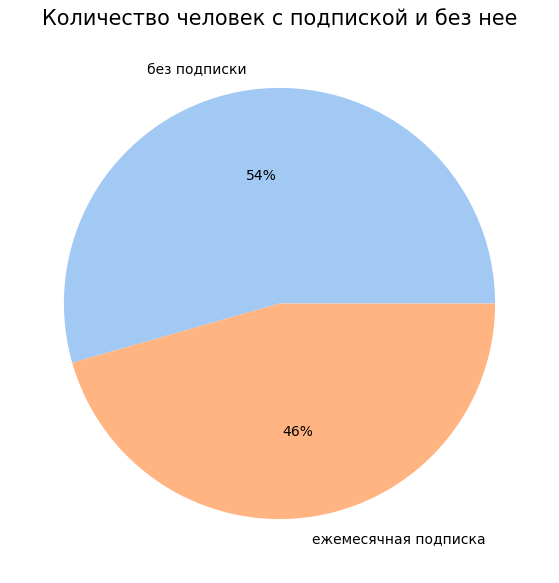

In [18]:
# считаем сколько пользователей с подпиской и без и отражаем результат на графике

print(users_data['subscription_type'].value_counts())

colors = sns.color_palette('pastel')[ 0:5 ]
sub_type_plot = plt.figure(figsize =(10, 7))
plt.pie(users_data['subscription_type'].value_counts(), labels = ['без подписки', 'ежемесячная подписка'], 
        colors = colors, autopct='%.0f%%')
plt.title("Количество человек с подпиской и без нее", fontsize=15)
plt.show()

Пользователей без подписки больше - 835, оплачивающих подписку - 699. Опять же нельзя сказать, что значения имеют большой разрыв. 

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


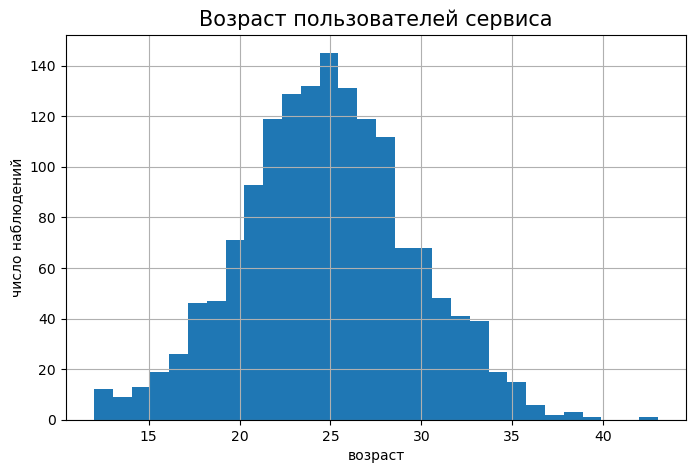

In [19]:
# изучаем распределение пользователей по возрасту, визуализируем полученный результат. 

print(users_data['age'].describe())
users_data['age'].hist(bins=30, figsize=(8,5))
plt.title("Возраст пользователей сервиса", fontsize=15)
plt.xlabel("возраст", fontsize=10)
plt.ylabel("число наблюдений", fontsize=10)
plt.show()

По графику мы видим, что распределение пользователей по возрасту схоже с нормальным распределением, так как напоминает колокол, а медиана и среднее близки по значению. Больше всего пользователей от 20 до 30 лет, об этом говорят и показатели квартилей: Q1 - 22, Q3 - 28. Средний возраст пользователей - 25 лет. 

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


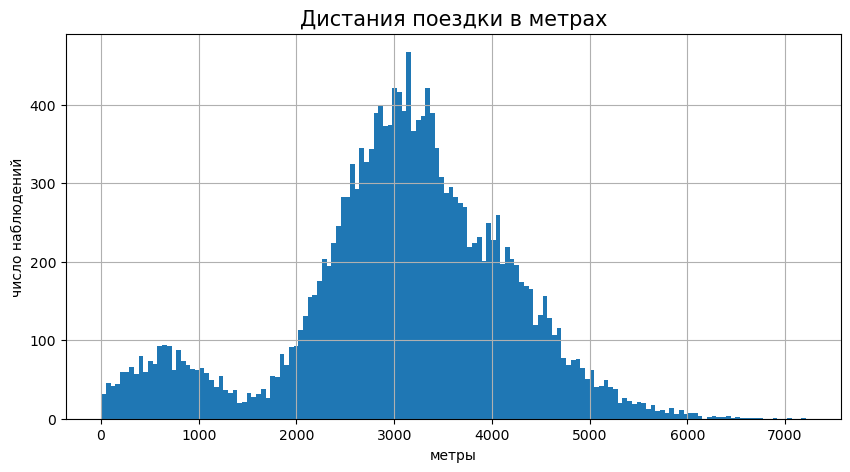

In [20]:
# определяем какое расстояние пользователи преодолевают за одну поездку.

print(rides_data['distance'].describe())
rides_data['distance'].hist(bins=150, figsize=(10,5))
plt.title("Дистания поездки в метрах", fontsize=15)
plt.xlabel("метры", fontsize=10)
plt.ylabel("число наблюдений", fontsize=10)
plt.show()

На графике мы видим два пика, примерно около 700 и 3000 метров. Интересно, что есть поездки близкие к 0, а на отметке 1,5 км можно заметить "провал", где показатель достигает примерно 50. Основной объем данных находится между 2500 и 4000 метров, после этой отметки мы видим резкое снижение показателя, получается, что люди редко проезжают на самокате более 4 км.  

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64


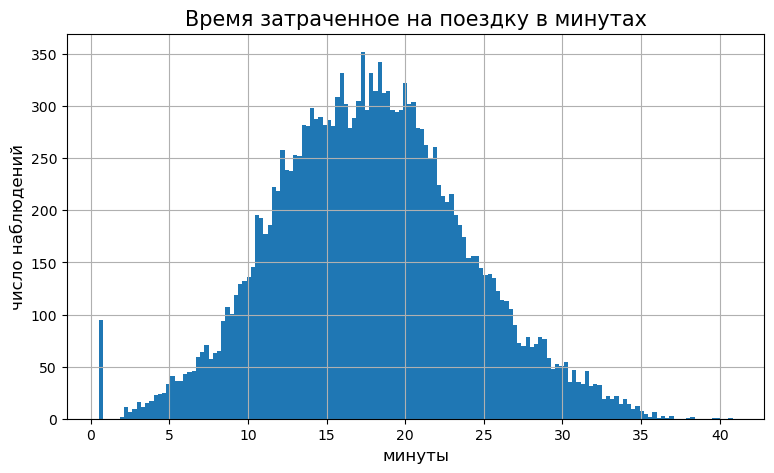

In [21]:
# определяем сколько пользователи тратят на поездку

print(rides_data['duration'].describe())
rides_data['duration'].hist(bins=150, figsize=(9,5))
plt.title("Время затраченное на поездку в минутах", fontsize=15)
plt.xlabel("минуты", fontsize=12)
plt.ylabel("число наблюдений", fontsize=12)
plt.show()

Есть четко выделяющийся маленький пик около 0 минут (таких поездок 100), это те поездки, которые начали и сразу же закончили по каким-то причинам. Если смотреть по графику, то основной объем значений лежит между 12 и 22, примерно такие же цифры показывают квартили. После 22 минут мы наблюдаем быстрый спад, поездки более 30 минут встречаются совсем редко, частота не превышает 40 и стретится вниз. 

График распределения продолжительности поездок представляет нормальное распределение, его среднее и медина почти равны. 

#### Шаг 4. Объединение данных

In [22]:
# объединяем датафрейм с данными о пользователях с датафреймом с данными о поездках по столбцу "user_id"

user_ride_data = users_data.merge(rides_data, on='user_id', how='inner')
user_ride_data.head(10)

,index,user_id,name,age,city,subscription_type,distance,duration,date,month
0,0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,0,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,0,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,0,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,0,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,0,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,0,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,0,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,0,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,0,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


In [23]:
# теперь добавляем данные о подписках, стоимости старта и поездок

user_ride_data = user_ride_data.merge(subscriptions_data, on='subscription_type', how='inner')
user_ride_data.head()

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [24]:
print('Размер таблицы users_data:', users_data.shape)
print('Размер таблицы rides_data:', rides_data.shape)
print('Размер таблицы subscriptions_data:', subscriptions_data.shape)
print('Размер таблицы user_ride_data:', user_ride_data.shape)

Размер таблицы users_data: (1534, 6)
Размер таблицы rides_data: (18068, 5)
Размер таблицы subscriptions_data: (2, 4)
Размер таблицы user_ride_data: (18068, 13)


Количество строк новой таблицы совпаает с rides_data (таблица с поездками), значит все правильно.

In [25]:
# создаем таблицу с данными о пользователях без подписки

user_ride_free_data = user_ride_data[user_ride_data['subscription_type'] == 'free']
user_ride_free_data.head()

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,699,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,699,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,699,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,699,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,699,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


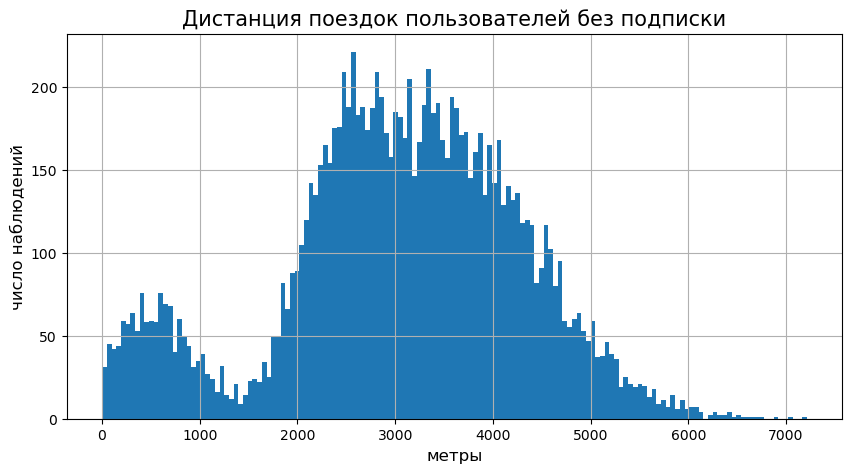

1223

In [26]:
# изучаем дистанцию поездок пользователей без подписки

print(user_ride_free_data['distance'].describe())
user_ride_free_data['distance'].hist(bins=150, figsize=(10,5))
plt.title("Дистанция поездок пользователей без подписки", fontsize=15)
plt.xlabel("метры", fontsize=12)
plt.ylabel("число наблюдений", fontsize=12)
plt.show()
user_ride_free_data['distance'][user_ride_free_data['distance'] < 1200].count()

Мы уже рассматривали график дистанции поездок выше, этот график с ним схож. Мы снова видим подъем около 700, "волна" от 0 до 1000 метром, на отметке 1,5 км спад до 25. Основной объем значений находится между 2300 и 4000 метров, то же самое можно увидеть в выводе описательной статистики, в значениях квартилей. После отметки в 4,8км частота не понимается выше 100. 

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


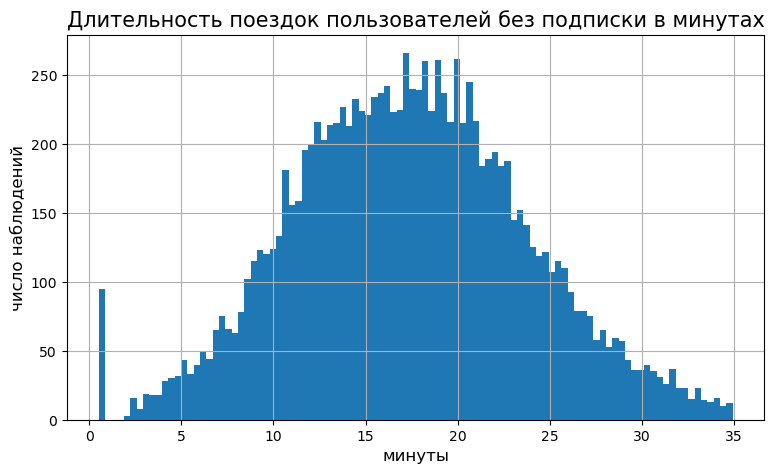

In [27]:
print(user_ride_free_data['duration'].describe())
user_ride_free_data['duration'].hist(bins=100, figsize=(9,5))
plt.title("Длительность поездок пользователей без подписки в минутах", fontsize=15)
plt.xlabel("минуты", fontsize=12)
plt.ylabel("число наблюдений", fontsize=12)
plt.show()

На графике мы видим пик около 0 минут, такой же пик был на графике продолжительности поездок выше, где пользователи еще не были разделены по подпискам. Основной объем значений лежит между отметками 12 и 21. Форма графика похожа на нормальное распределение, среднее и медиана равны, что также указывает на это. 

In [28]:
# создаем таблицу с данными о пользователях с подпиской

user_ride_ultra_data = user_ride_data[user_ride_data['subscription_type'] == 'ultra']
user_ride_ultra_data.head()

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,0,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,0,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,0,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,0,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


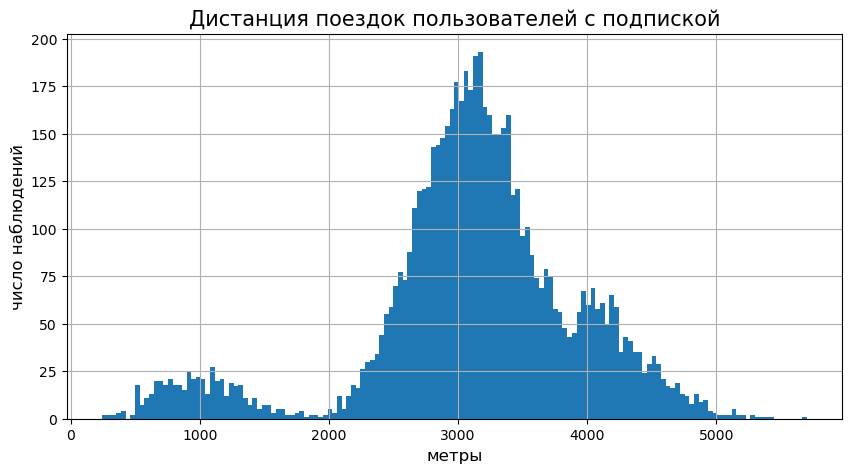

368

In [29]:
# выводим описательную статистику и график для дистанции поездок пользователей с подписками

print(user_ride_ultra_data['distance'].describe())
user_ride_ultra_data['distance'].hist(bins=150, figsize=(10,5))
plt.title("Дистанция поездок пользователей с подпиской", fontsize=15)
plt.xlabel("метры", fontsize=12)
plt.ylabel("число наблюдений", fontsize=12)
plt.show()
user_ride_ultra_data['distance'][user_ride_ultra_data['distance'] < 1200].count()

У "подписчиков" также есть небольшой всплеск около 1000 метров, но частота значений здесь намного ниже, чем у пользователей без подписки. Мы видим на графике еще два пика. Самый высокий около 3100 метров, где частота достигает почти 300, второй на отметке 4000 метров, где максимальный показатель частоты равен 100. Основной объем значений находится между отметками 2500 и 3700 метров. После второго пика на 4 км, частота быстро снижается.

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


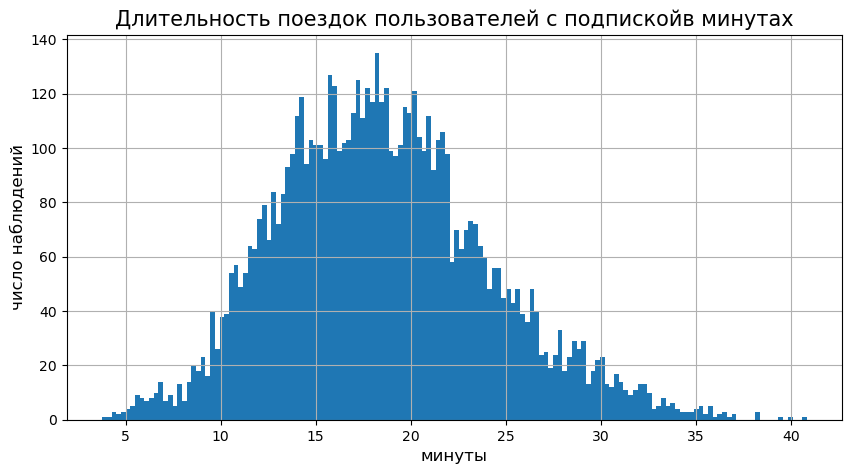

In [30]:
# выводим описательную статистику и график для продолжительности поездок пользователей с подписками


print(user_ride_ultra_data['duration'].describe())
user_ride_ultra_data['duration'].hist(bins=150, figsize=(10,5))
plt.title("Длительность поездок пользователей с подпискойв минутах", fontsize=15)
plt.xlabel("минуты", fontsize=12)
plt.ylabel("число наблюдений", fontsize=12)
plt.show()

Этот график также похож на нормальное распределение, хотя отличие медианы от среднее чуть больше, чем в других случаях. Основной объем значений лежит между 14 и 22, это видно из описательной статистики (первый и последний квартили), а также на графике. Поездок более 30 минут почти нет (частота таких поездок ниже 20).

**Вывод к разделу** 

Мы объединили все данные в один датафрейм, также создали два более мелких, чтобы разделить пользователей с подпиской и без нее и проанализировали два параметра для каждой группы. Этими параметрами являются время поездки и ее дистанция. Для анализа этих параметров были выведены описательные статистики и построены графики. Время и расстояние поездок для двух групп пользователей действительно отличаются.

1. Пользователи без подписки чаще совершают поездки до 1,5 км, чем пользователи с подпиской. На гистограмме для всех пользователей мы видели, что есть небольшой подъем на отрезке 0 - 1200 метров (примерно), где показатель частоты достигает примерно 75. На графике пользователей без подписки показатель частоты такой же, а у подписчиков частота поездок на расстояние до 1200 метров в наивысшей точке достигает 25. 

Вывод: пользователи без подписки чаще, чем пользователи с подпиской, берут самокат для короткой поездки (до 1200 метров).

2. На графиках длительности поездок также есть различие. На гистограмме пользователей без подписки есть пик около 0 до значения частоты почти 100, на графике пользователей с подпиской такого нет. Причин таких коротких поездок может быть много. Например, человек не смог разобраться с интерфейсом, логично предположить, что пользователь без подписки не так часто берет самокат и хуже знаком с ним и приложением. Или это была вообще первая поездка человека. Могли быть и какие-то случайности. Человек не разобрался, как ездить на самокате или побоялся не справиться с управлением на оживленной улице. 


#### Шаг 5. Подсчёт выручки

Создадим общий датафрейм, где укажем всю доступную информацию для конкретного пользователя по месяцам

In [31]:
# округляем значения времени и расстояния в большую сторону до целого

user_ride_data['duration'] = np.ceil(user_ride_data['duration']) 
user_ride_data['distance'] = np.ceil(user_ride_data['distance'])

# создаем сводную таблицу, где за основные категории берем id пользователей, 
# а суб-категориями являются номера месяцев, в которые совершены поездки.

money_users_data = user_ride_data.pivot_table(
    index=['user_id','month'],
    values=['duration', 'distance','name', 'start_ride_price','subscription_fee','subscription_type','minute_price'], 
    aggfunc={'duration':'sum', 'distance':'sum', 'name':'count', 
            'start_ride_price':'max','subscription_fee':'max','subscription_type':'max','minute_price':'max'} )

money_users_data.head(15)

distance  duration  minute_price  name  start_ride_price  \
user_id month                                                             
1       1        7028.0      42.0             6     2                 0   
        4         755.0       7.0             6     1                 0   
        8        6724.0      46.0             6     2                 0   
        10       5811.0      32.0             6     2                 0   
        11       7005.0      56.0             6     3                 0   
        12       6753.0      28.0             6     2                 0   
2       3       10190.0      63.0             6     3                 0   
        4        6165.0      40.0             6     2                 0   
        6        3256.0      14.0             6     1                 0   
        7        6781.0      48.0             6     2                 0   
        8         924.0       7.0             6     1                 0   
        10       2825.0      19.0             6     1                 0   
        12       3829.0      12.0             6     1                 0   
3       1        3062.0      13.0             6     1                 0   
        2        5422.0      39.0             6     2                 0   

               subscription_fee subscription_type  
user_id month                                      
1       1                   199             ultra  
        4                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        11                  199             ultra  
        12                  199             ultra  
2       3                   199             ultra  
        4                   199             ultra  
        6                   199             ultra  
        7                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        12                  199             ultra  
3       1                   199             ultra  
        2                   199             ultra

5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [32]:
# добавляем столбец с месячной выручкой, использую для ее подсчета формулу

money_users_data['revenue'] = money_users_data['start_ride_price'] * money_users_data['name'] + \
money_users_data['minute_price'] * money_users_data['duration'] + money_users_data['subscription_fee']
money_users_data.head(10)

distance  duration  minute_price  name  start_ride_price  \
user_id month                                                             
1       1        7028.0      42.0             6     2                 0   
        4         755.0       7.0             6     1                 0   
        8        6724.0      46.0             6     2                 0   
        10       5811.0      32.0             6     2                 0   
        11       7005.0      56.0             6     3                 0   
        12       6753.0      28.0             6     2                 0   
2       3       10190.0      63.0             6     3                 0   
        4        6165.0      40.0             6     2                 0   
        6        3256.0      14.0             6     1                 0   
        7        6781.0      48.0             6     2                 0   

               subscription_fee subscription_type  revenue  
user_id month                                               
1       1                   199             ultra    451.0  
        4                   199             ultra    241.0  
        8                   199             ultra    475.0  
        10                  199             ultra    391.0  
        11                  199             ultra    535.0  
        12                  199             ultra    367.0  
2       3                   199             ultra    577.0  
        4                   199             ultra    439.0  
        6                   199             ultra    283.0  
        7                   199             ultra    487.0

На этом этапе мы агрегировали данные в единый датафрейм, на основе которого далее сможем проверять гипотезы, а также добавили расчеты помесячной выручки от каждого пользователя.

#### Шаг 6. Проверка гипотез

**Задание 6.1**

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

**Нулевая гипотеза**: Среднее время поездки пользователей с подпиской равно среднему времени поездки пользователей без подписки

**Альтернативная гипотеза** : Среднее время поездки пользователей с подпиской больше среднего времени поездки пользователей без подписки

In [33]:
alpha = 0.05

result_1 = st.ttest_ind(user_ride_ultra_data['duration'], user_ride_free_data['duration'], alternative='greater', 
                        equal_var=True)

print('p-значение:', result_1.pvalue)
if result_1.pvalue < alpha:
    print('Нулевая гипотеза отвергается')
else:
    print('Мы не можем отвергнуть нулевую гипотезу')
    
print()

p-значение: 1.2804098316645618e-34
Нулевая гипотеза отвергается



**Вывод**: Из расчетов мы можем сделать вывод, что среднее время поездки пользователей с подпиской неравно среднему времени поездки пользователей без подписки, а значит пользователи с подпиской могут тратить больше времени на поездки, чем пользователи без нее.

**Задание 6.2** 

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

**Нулевая гип.**: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров

**Альтернативная гип.**: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров

In [34]:
distance = 3130

alpha = 0.05
result_2 = st.ttest_1samp(user_ride_ultra_data['distance'], distance, alternative='greater')

print('p-значение:', result_2.pvalue)
if result_2.pvalue < alpha:
    print('Нулевая гипотеза отвергается')
else:
    print('Мы не можем отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Мы не можем отвергнуть нулевую гипотезу


Исходя из полученных результатов, мы не можем отвергнуть гипотезу о средней дистанции поездки пользователей с подпиской в 3130 метров. Если вспомнить ранее полученный график, то он скорее говорит в пользу этой гипотезы, также, как и описательная статистика, в которой среднее равнялось 3115 метрам. 

**Задание 6.3.**

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

**Нулевая гипотеза**: Средняя выручка от пользователей с подпиской равна выручке от пользователей без подписки.

**Альтернативная гипотеза** : Средняя выручка от пользователей с подпиской больше средней выручки от пользователей без подписки.

In [35]:
revenue_ultra = money_users_data[money_users_data['subscription_type'] == 'ultra']
revenue_free = money_users_data[money_users_data['subscription_type'] == 'free']

alpha = 0.05
result_3 = st.ttest_ind(revenue_ultra['revenue'], revenue_free['revenue'], alternative='greater')

print('p-значение:', result_3.pvalue)
if result_3.pvalue < alpha:
    print('Нулевая гипотеза отвергается')
else:
    print('Мы не можем отвергнуть нулевую гипотезу')
    
print('Среднее значение выручки оттпользователей с платной подпиской', revenue_ultra['revenue'].mean())
print('Среднее значение выручки от пользователей без подписки', revenue_free['revenue'].mean())

p-значение: 1.8850394384715216e-31
Нулевая гипотеза отвергается
Среднее значение выручки оттпользователей с платной подпиской 362.7921906022502
Среднее значение выручки от пользователей без подписки 328.6413651073845


**Вывод:** исходя из расчетов можно заключить, что выручки от двух групп пользователей не равны, пользователи с платной подпиской приносят больше денег сервису, это также видно, если сравнить значения средних выручек. 

6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

В данной ситуации мы должны использовать тест для зависимых (парных) выборок. Такие выборки содержат данные до и после изменения конкретной переменной, которую анализируют. Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых  выборок в Python, используется метод scipy.stats.ttest_rel(), в аргументах которого указывают две зависимые выборки. 

Проведя небольшое исследование, мы можем сделать несколько выводов по полученным данным. Пользователи с подпиской могут тратить больше времени на поездки, чем пользователи без нее. Мы не можем отвергнуть гипотезу о том, что среднее расстояние поездок пользователей с подпиской равно 3130. И наконец расчеты показали, что выручки от двух групп пользователей с разными типами подписки могут быть равны. 

**Общий вывод**

    Получив три набора данных мы сохранили их в переменных, изучили основную информацию и осуществили предобработку данных. В ходе последней были устранены дубликаты в датафрейме с информацией о пользователях, а также исправлен тип данных в столбце с датой поездки в наборе данных с информацией о поездках. Иных дубликатов или пропусков не было обнаружено.

    Выведя основные значения описательной статистики и визуализировав их в гистограммах, мы смогли изучить характер распределения некоторых параментов. Самым частым городом оказался Пятигоркс - 219, а на последнем месте Москва - 168. Между ними распологаются остальные 6 городов с небольшой разницей в частоте между собой. Нельзя сказать, что какой-то город сильно выделяется по встребованности. Также и с подписками, пользователей без нее больше - 835, оплачивающих - 699, опять же не такое серьезное различие, чтобы говорить о явных предпочтениях. Вполне естественно, что "подписчиков" меньше, это люди, которые пользуются самокатами часто, которым подписка выгоднее. И наоборот людей, берущих самокат раз в месяц, будет больше. 

    Распределение пользователей по возрасту схоже с нормальным распределением. Больше всего людей от 20 до 30 лет. Средний возраст - 25 лет. Чаще всего пользователи преодолевают от 2,5 до 4 км на самокате, но есть и короткие поездки чуть более 1 км, они 3 раза чаще встречаются у клиентов без подписки. На графиках длительности поездок также есть различие. На гистограмме пользователей без подписки есть пик около 0 до значения частоты почти 100, на графике пользователей с подпиской такого нет. 
    
    Для дальнейшего исследования потребовалось объединить все данные из 3 датафреймов, для чего была использована сводная таблица. Затем в нее был добавлен столбец с помесячой выручкой для каждого пользователя.
    
    Проведя небольшое исследование, в ходе которого были использованы методы библиотек pandas, matplotlib.pyplot, numpy, scipy.stats и знания о способах проверки гипотез, мы можем сделать несколько выводов по полученным данным. Пользователи с подпиской могут тратить больше времени на поездки, чем пользователи без нее. Мы не можем отвергнуть гипотезу о том, что среднее расстояние поездок пользователей с подпиской равно 3130. И наконец расчеты показали, что выручки от двух групп пользователей с разными типами подписки не равны.  